In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from dateutil.relativedelta import relativedelta

import scipy.stats as scs
# from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize

from sklearn.metrics import mean_absolute_error, mean_squared_error

# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split # разбиение данных на тренировочные и тестовые


from sklearn.preprocessing import StandardScaler # нормализация и масштабирование данных

from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import cross_val_score # кроссвалидация
from sklearn.model_selection import GridSearchCV # подбор гиперпараметров с кроссвалидацией

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBRegressor

import statsmodels

import gc
import glob
import os

%matplotlib inline

from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from numpy import percentile
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples
from tqdm import tqdm
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/k8s/datasets/nabout.csv")

df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df_anomaly = df.copy()
df = df[['cpu_usage',	'net_usage',	'disk_usage']]
df

,cpu_usage,net_usage,disk_usage
timestamp,,,
2014-02-14 14:30:00,0.132,236906.0,43216100.0
2014-02-14 14:35:00,0.134,247200.0,863964000.0
2014-02-14 14:40:00,0.134,244932.0,128310000.0
2014-02-14 14:45:00,0.134,249894.0,0.0
2014-02-14 14:50:00,0.134,226273.0,125814000.0
...,...,...,...
2014-03-13 14:04:00,0.066,219813.0,7878250.0
2014-03-13 14:09:00,0.068,207644.0,107195000.0
2014-03-13 14:14:00,0.134,204319.0,44328600.0


In [ ]:
for column in df.columns:
    fig = px.line(df, x=df.index, y=[column], title='AWS ' + column, template = 'plotly_dark')
    fig.show()

# IQR

In [ ]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std

    # интерквантильный размах
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)

    # насколько размахов отступать
    up_bound_iqr = data[col].quantile(0.75) + (IQR * threshold)
    low_bound_iqr = data[col].quantile(0.25) - (IQR * threshold)

    anomalies = pd.concat([(data[col]>up_bound) | (data[col]>up_bound_iqr), (data[col]<low_bound) | (data[col]<low_bound_iqr)], axis=1).any(1)
    return anomalies, up_bound, low_bound, up_bound_iqr, low_bound_iqr, mean, std

In [ ]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns

    outliers = pd.Series(data=[False]*len(data), index=data.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound, up_bound_iqr, low_bound_iqr, mean, std = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, up_bound_iqr, low_bound_iqr, mean, std, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True

    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'up_bound_iqr', 'low_bound_iqr', 'mean', 'std', 'anomalies_count', 'anomalies_percentage']

    return comparison_table, outliers

In [ ]:
column_usage = 'cpu_usage'
comparison_table, std_outliers = get_column_outliers(df[[column_usage]])

comparison_table

,upper_bound,lower_bound,up_bound_iqr,low_bound_iqr,mean,std,anomalies_count,anomalies_percentage
cpu_usage,0.385303,-0.169618,0.338,-0.138,0.107843,0.092487,29.0,0.37299


In [ ]:
std_outliers

timestamp
2014-02-14 14:30:00    False
2014-02-14 14:35:00    False
2014-02-14 14:40:00    False
2014-02-14 14:45:00    False
2014-02-14 14:50:00    False
                       ...  
2014-03-13 14:04:00    False
2014-03-13 14:09:00    False
2014-03-13 14:14:00    False
2014-03-13 14:19:00    False
2014-03-13 14:24:00    False
Name: is_outlier, Length: 7775, dtype: bool

In [ ]:
def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))

In [ ]:
anomalies_report(std_outliers)

Total number of outliers: 29
Percentage of outliers:   0.37%


In [ ]:
dfx = df.copy()
dfx['is_outlier'] = std_outliers

dfx["outlier"] = dfx["is_outlier"].astype(int)
dfx.head()

,cpu_usage,net_usage,disk_usage,is_outlier,outlier
timestamp,,,,,
2014-02-14 14:30:00,0.132,236906.0,43216100.0,False,0
2014-02-14 14:35:00,0.134,247200.0,863964000.0,False,0
2014-02-14 14:40:00,0.134,244932.0,128310000.0,False,0
2014-02-14 14:45:00,0.134,249894.0,0.0,False,0
2014-02-14 14:50:00,0.134,226273.0,125814000.0,False,0


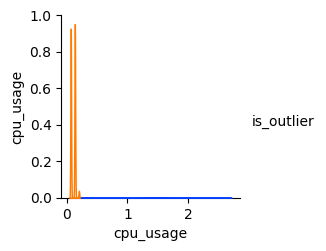

In [ ]:
sns.pairplot(data=dfx, vars = df[[column_usage]],
             hue='is_outlier', hue_order=[1, 0],
             markers=['*', 'o'],  palette='bright');

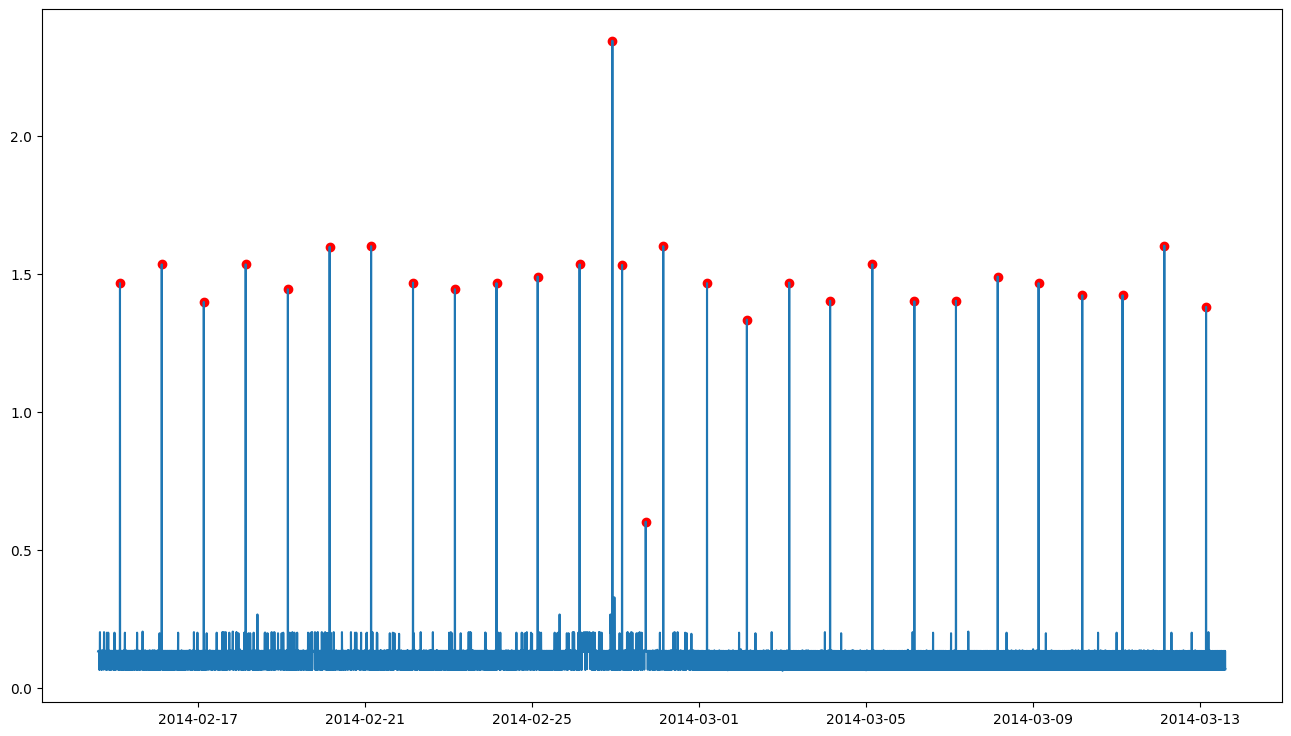

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
a = dfx.loc[dfx.outlier == 1, [column_usage]]

ax.plot(dfx.index, dfx[column_usage])
ax.scatter(a.index, a[column_usage], color='red')
plt.show()

In [ ]:
# Define colors for anomalies and non-anomalies
y_pred = dfx['outlier']
X = df.copy()
colors = ['green' if a == 0 else 'red' for a in y_pred]

# Create a scatter plot of the data with anomalies highlighted in red
fig = go.Figure(data=go.Scatter(x=dfx.index, y=dfx[column_usage],
                                 mode='markers', marker=dict(color=colors, size=3)))

# Set the title and axis labels for the plot
fig.update_layout(title=dict(text='LOF Anomaly prediction', x=0.5),
                  yaxis_title='Value',
                  xaxis_title='Timestamp')

# Show the plot
fig.show()

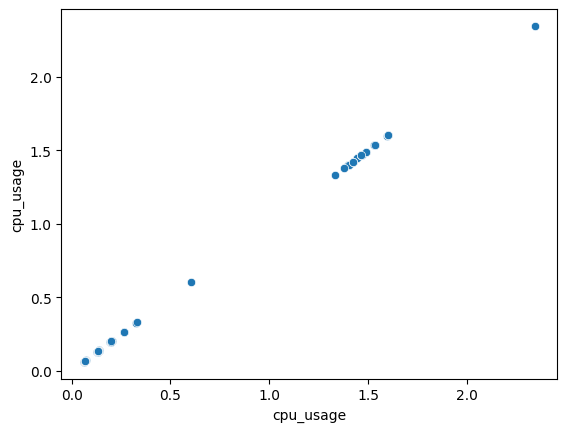

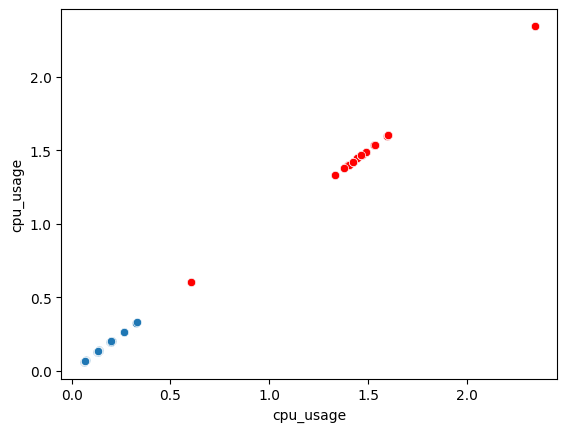

In [ ]:
sns.scatterplot(
        df,
        x=column_usage,
        y=column_usage
    )
plt.show()

sns.scatterplot(
        df,
        x=column_usage,
        y=column_usage
    )


sns.scatterplot(
        dfx.loc[dfx.outlier == 1],
        x=column_usage,
        y=column_usage,
        color='red'
    )
plt.show()

# Metrics


In [ ]:
y_pred = y_pred == 0
dfx['name'] = y_pred
y_pred

timestamp
2014-02-14 14:30:00    True
2014-02-14 14:35:00    True
2014-02-14 14:40:00    True
2014-02-14 14:45:00    True
2014-02-14 14:50:00    True
                       ... 
2014-03-13 14:04:00    True
2014-03-13 14:09:00    True
2014-03-13 14:14:00    True
2014-03-13 14:19:00    True
2014-03-13 14:24:00    True
Name: outlier, Length: 7775, dtype: bool

In [ ]:
p_values = {}
p_stats_ = {}
percent = {}
silhoutte = {}
calinski_harabasz = {}
davies_bouldin = {}

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

cols_in = [column_usage]

In [ ]:
dfx['name'].value_counts()

True     7746
False      29
Name: name, dtype: int64

In [ ]:
#percent anomaly
dist = dfx['name'].value_counts(normalize=True)
print(dist)
percent['name'] = dist.loc[True]

True     0.99627
False    0.00373
Name: name, dtype: float64


In [ ]:
#silhouette conficient samples non-anomaly
labels = [1 if i == True else 2 for i in dfx['name']]
dfx['silhouette_zcore_'] = silhouette_samples(df[[column_usage]], labels)
silhoutte['name'] = dfx[dfx['name']]['silhouette_zcore_'].mean()

In [ ]:
#ks coeficient
normal = dfx.loc[dfx['name'] == False, [column_usage]]
anomaly = dfx.loc[dfx['name'] == True, [column_usage]]
for col_in in tqdm(cols_in):
  if len(normal)>0 and len(anomaly)>0:
    stats_, pvalue = stats.kstest(normal[col_in], anomaly[col_in])
    p_values[col_in+'_'] = pvalue
    p_stats_[col_in+'_'] = stats_

100%|██████████| 1/1 [00:00<00:00, 210.44it/s]


In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_index = calinski_harabasz_score(df[[column_usage]], labels)
calinski_harabasz['name'] = round(ch_index, 3)
print("Calinski-Harabasz Index:", round(ch_index, 3))

Calinski-Harabasz Index: 35640.883


In [ ]:
from sklearn.metrics import davies_bouldin_score

dbi = davies_bouldin_score(df[[column_usage]], labels)
davies_bouldin['name'] = round(dbi, 3)
print("Davies-Bouldin Index:", round(dbi, 3))

Davies-Bouldin Index: 0.109


pvalue
  svm_algorithm        pvalue
0    cpu_usage_  2.753996e-82
{'cpu_usage_': 2.7539960600607103e-82}


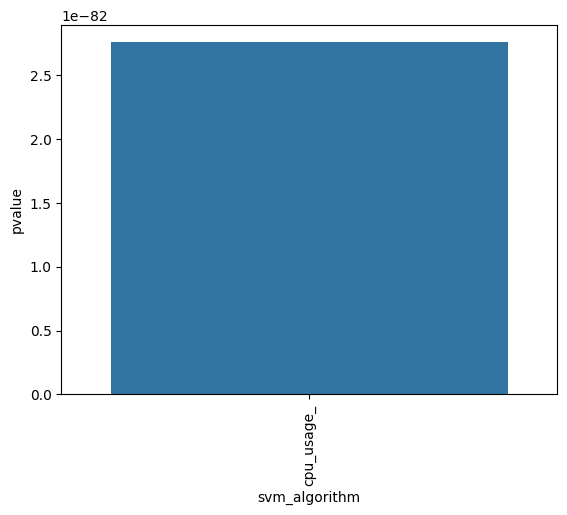

statistics
  svm_algorithm  statistics
0    cpu_usage_         1.0
{'cpu_usage_': 1.0}


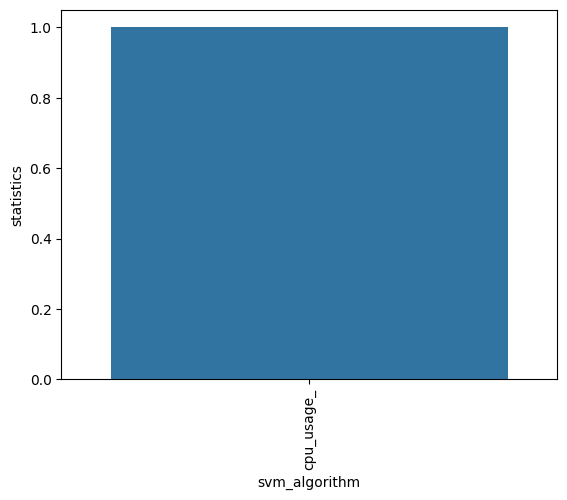

percent
  svm_algorithm  percent
0          name  0.99627
{'name': 0.9962700964630226}


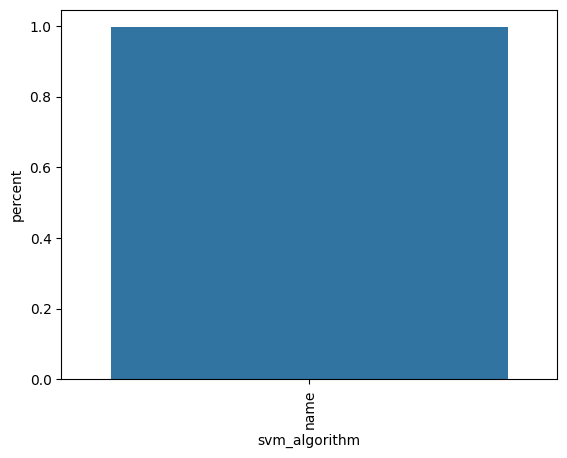

silhoutte
  svm_algorithm  silhoutte
0          name   0.973163
{'name': 0.9731633646333726}


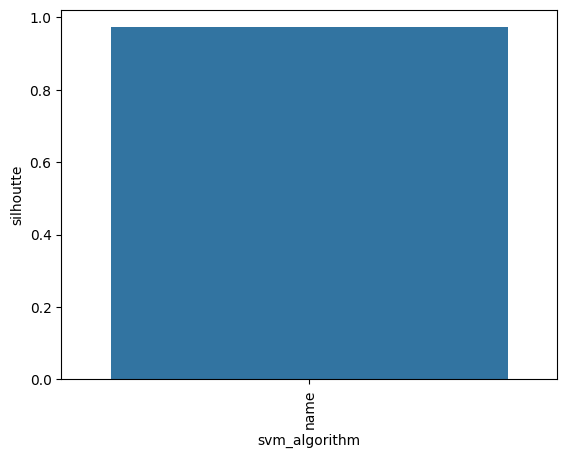

calinski_harabasz
  svm_algorithm  calinski_harabasz
0          name          35640.883
{'name': 35640.883}


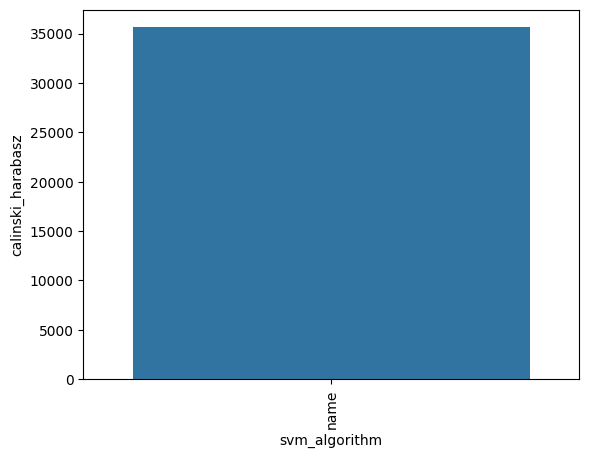

davies_bouldin
  svm_algorithm  davies_bouldin
0          name           0.109
{'name': 0.109}


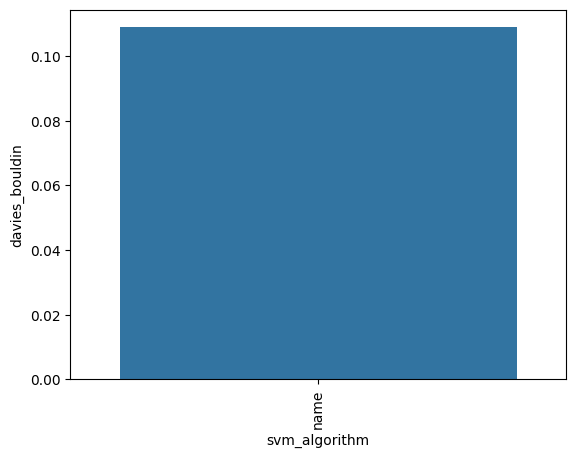

In [ ]:
for name, dictionary in {'pvalue': p_values, 'statistics': p_stats_, 'percent': percent, 'silhoutte':silhoutte, 'calinski_harabasz': calinski_harabasz, 'davies_bouldin': davies_bouldin}.items():
    print(name)
    df_values =  pd.DataFrame([dictionary])
    df_values = df_values.T
    df_values.reset_index(inplace=True)
    df_values.columns = ['svm_algorithm', name]
    print(df_values)
    print(dictionary)

    sns.barplot(data=df_values, x='svm_algorithm', y=name)
    plt.xticks(df_values.index, df_values['svm_algorithm'].values, rotation=90)
    plt.show()

In [ ]:
for name, dictionary in {'pvalue': p_values, 'statistics': p_stats_, 'percent': percent, 'silhoutte':silhoutte, 'calinski_harabasz': calinski_harabasz, 'davies_bouldin': davies_bouldin}.items():
    print(name + ': ' + str(np.array(list(dictionary.values())).mean()))

pvalue: 2.7539960600607103e-82
statistics: 1.0
percent: 0.9962700964630226
silhoutte: 0.9731633646333726
calinski_harabasz: 35640.883
davies_bouldin: 0.109


In [ ]:
svm_df = pd.DataFrame()
svm_df['anomaly']  = [1 if i==True else 0 for i in df_anomaly.anomaly]

svm_f1 = f1_score(dfx['outlier'], svm_df['anomaly'])
print(f'One Class SVM F1 Score : {round(svm_f1 * 100,2)}%')

One Class SVM F1 Score : 16.43%
